In [4]:
from pathlib import Path   
import os                  

import numpy as np
import matplotlib.pyplot as plt
import cv2                # For image processing

# TensorFlow and Keras for deep learning
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Scikit-learn for data preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  # To convert a class vector (integers) to a binary class matrix
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
def process_images_from_directory(directory, label, size):
    
    images_list = []
    for image_path in directory.iterdir():
        try:
            if image_path.suffix == '.png':
                # Read the image using OpenCV
                image = cv2.imread(str(image_path))

                # Convert the image to RGB (OpenCV uses BGR by default)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize the image
                image_resized = cv2.resize(image_rgb, (size, size))

                images_list.append(image_resized)
                label.append(0 if directory.name == 'Parasitized' else 1)
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    return images_list

In [8]:
dataset_path_parasitized = Path("C:\\Users\\91701\\Downloads\\malaria diease1\\cell_images\\cell_images\\Parasitized")
dataset_path_uninfected  = Path("C:\\Users\\91701\\Downloads\\malaria diease1\\cell_images\\cell_images\\Uninfected")


In [9]:
SIZE      = 64    
dataset   = []    
label     = []    

dataset = process_images_from_directory(dataset_path_parasitized, label, SIZE)
dataset.extend(process_images_from_directory(dataset_path_uninfected, label, SIZE))

### Data Exploratory Analysis (EDA)


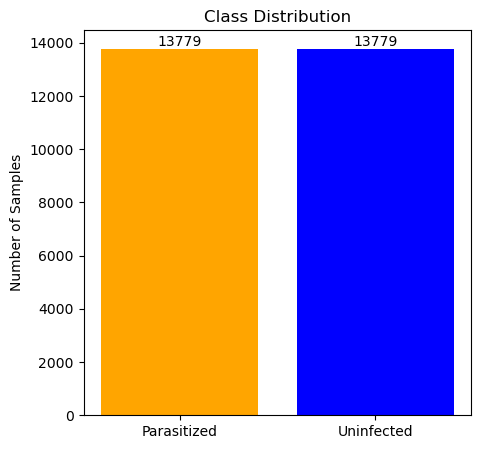

In [10]:
# Data for plotting
categories = ['Parasitized', 'Uninfected']
values     = [label.count(0), label.count(1)]
colors     = ['orange', 'blue']  

plt.figure(figsize = (5, 5))  
bars = plt.bar(categories, values, color = colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.title('Class Distribution')
plt.ylabel('Number of Samples')

plt.show()

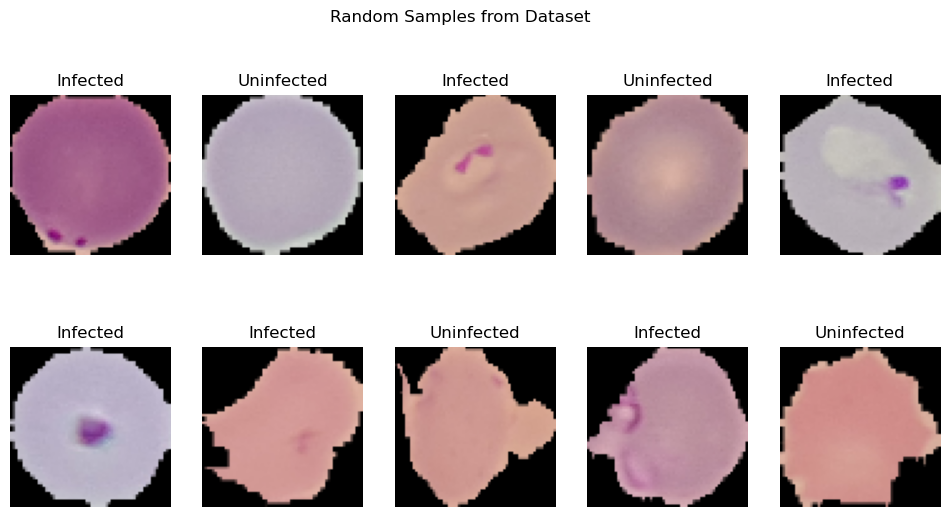

In [11]:
# Display some sample images:
def display_samples(samples, labels, title):
    plt.figure(figsize=(12, 6))
    for index, (image, label) in enumerate(zip(samples, labels)):
        plt.subplot(2, 5, index + 1)
        plt.imshow(image)
        plt.title('Infected' if label == 0 else 'Uninfected')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

samples_to_display = 10

random_indices = np.random.choice(len(dataset), samples_to_display, replace=False)
samples = [dataset[i] for i in random_indices]
sample_labels = [label[i] for i in random_indices]

display_samples(samples, sample_labels, "Random Samples from Dataset")

### Model Architecture CNN

### Training & Validation

In [12]:
# Splitting the Dataset
X = np.array(dataset)
Y = to_categorical(np.array(label))
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [13]:
# Data Augmentation
# Define the ImageDataGenerator
data_generator = ImageDataGenerator(
    rotation_range    = 15,
    width_shift_range = 0.2,
    height_shift_range= 0.2,
    zoom_range        = 0.2,
    shear_range = 0.2,
    horizontal_flip   = True,
    vertical_flip     = True,
)

# to create the augmented data generator
augmented_data = data_generator.flow(X_train, y_train, batch_size = 64,shuffle = True)

In [14]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (22046, 64, 64, 3)
y_train shape: (22046, 2)
X_test shape: (5512, 64, 64, 3)
y_test shape: (5512, 2)


### Resnet50

In [15]:
import keras
from keras.applications import ResNet50
from keras.regularizers import l2

In [16]:
def dense_block(input_tensor, num_neurons):
    x = keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=l2(0.001))(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    return x

# Load the ResNet50 model without the top (classification) layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

# Freeze the convolutional layers to prevent training
for layer in resnet.layers:
    layer.trainable = False

# Flatten the output of ResNet50
x = keras.layers.Flatten()(resnet.output)

# Add dense layers
x = dense_block(x, 512)
x = dense_block(x, 256)

# Output layer
out = keras.layers.Dense(2, activation='sigmoid')(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 216s 2us/step


In [18]:
# Create the model
model = keras.Model(inputs=resnet.input, outputs=out)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 27,917,442 (106.50 MB)

 Trainable params: 4,328,194 (16.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

None


In [19]:
history = model.fit(
    augmented_data,
    verbose=1,
    epochs=45,
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) 
)


Epoch 1/45


C:\Users\91701\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  345/22046 ━━━━━━━━━━━━━━━━━━━━ 1:48:53 301ms/step - accuracy: 0.8314 - loss: 1.3946

C:\Users\91701\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


22046/22046 ━━━━━━━━━━━━━━━━━━━━ 144s 6ms/step - accuracy: 0.8486 - loss: 1.1154 - val_accuracy: 0.9053 - val_loss: 0.6550
Epoch 2/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 146s 7ms/step - accuracy: 0.8749 - loss: 0.6074 - val_accuracy: 0.8160 - val_loss: 0.6668
Epoch 3/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 161s 7ms/step - accuracy: 0.8750 - loss: 0.4767 - val_accuracy: 0.8879 - val_loss: 0.4118
Epoch 4/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 162s 7ms/step - accuracy: 0.8766 - loss: 0.4225 - val_accuracy: 0.8824 - val_loss: 0.3938
Epoch 5/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 159s 7ms/step - accuracy: 0.8788 - loss: 0.4007 - val_accuracy: 0.8973 - val_loss: 0.3407
Epoch 6/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 168s 8ms/step - accuracy: 0.8754 - loss: 0.3914 - val_accuracy: 0.8677 - val_loss: 0.4023
Epoch 7/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 162s 7ms/step - accuracy: 0.8759 - loss: 0.3888 - val_accuracy: 0.9031 - val_loss: 0.3351
Epoch 8/45
22046/22046 ━━━━━━━━━━━━━━━━━━━━ 174s 8ms/step - accuracy: 0.8

In [20]:
# Evaluate the model
scores = model.evaluate(np.array(X_test), np.array(y_test), verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
print(f"Test Loss: {scores[0]:.5f}")

# Predict classes with the model
predictions = model.predict(np.array(X_test))
predicted_classes = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to single-column format
y_test_single_column = np.argmax(y_test, axis=1)

# Generate classification report and confusion matrix
print(classification_report(y_test_single_column, predicted_classes))
print(confusion_matrix(y_test_single_column, predicted_classes))

Accuracy: 87.79%
Test Loss: 0.33398
173/173 ━━━━━━━━━━━━━━━━━━━━ 36s 198ms/step
              precision    recall  f1-score   support

           0       0.95      0.80      0.86      2703
           1       0.83      0.96      0.89      2809

    accuracy                           0.88      5512
   macro avg       0.89      0.88      0.88      5512
weighted avg       0.89      0.88      0.88      5512

[[2152  551]
 [ 122 2687]]


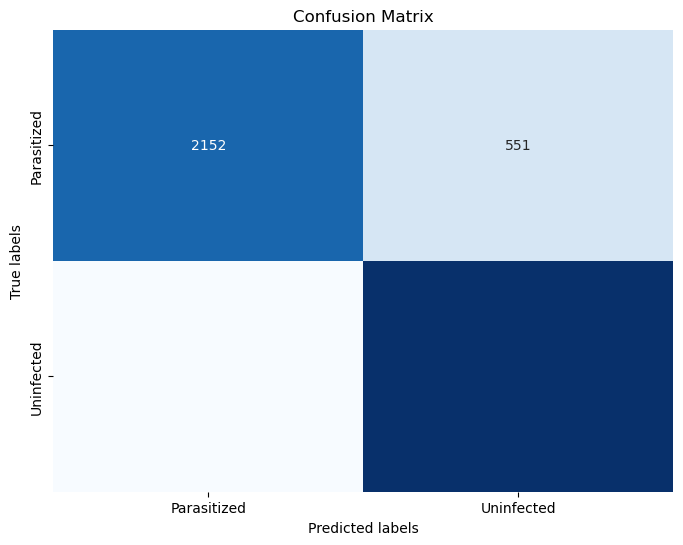

In [21]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_single_column, predicted_classes)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized', 'Uninfected'])
plt.show()

In [22]:
# Calculate the average training loss over all epochs
average_train_loss = np.mean(history.history['loss'])

# Get the training loss from the last epoch
final_train_loss = history.history['loss'][-1]

print(f"Average Training Loss: {average_train_loss:.5f}")
print(f"Final Training Loss: {final_train_loss:.5f}")

Average Training Loss: 0.37354
Final Training Loss: 0.32675


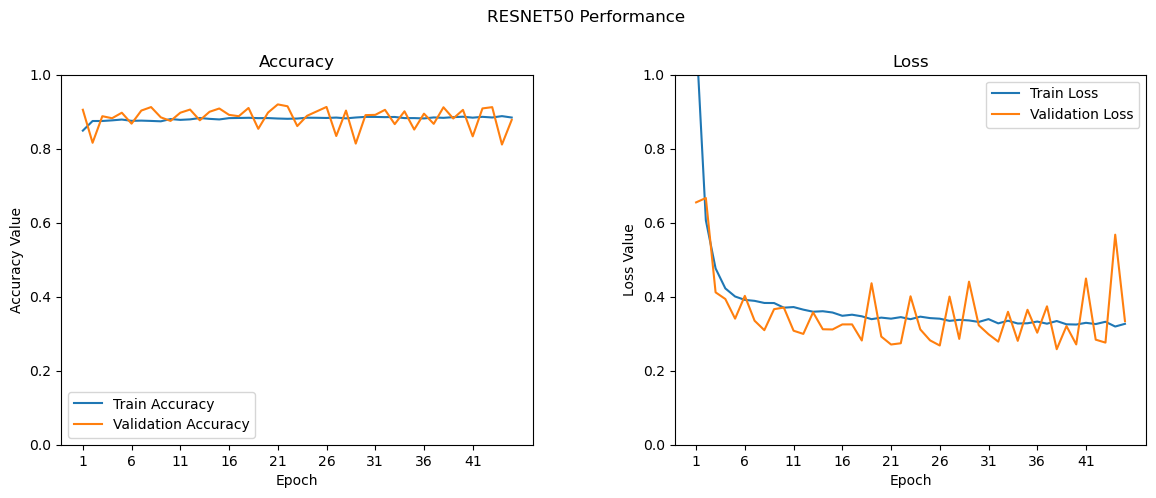

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('RESNET50 Performance', fontsize=12)
    fig.subplots_adjust(top=0.85, wspace=0.3)

    # Extract the number of epochs and create a list of epoch numbers
    max_epoch = len(history.history['accuracy'])
    epoch_list = list(range(1, max_epoch + 1))

    # Plot training and validation accuracy
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend(loc="best")
    ax1.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Plot training and validation loss
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch + 1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend(loc="best")
    ax2.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

    # Display the plots
    plt.show()

# Call the function to plot
plot_training_history(history)